#Install unzip and extract archive.zip

In [ ]:
!!apt install unzip

['',
 'Reading package lists... 0%',
 '',
 'Reading package lists... 0%',
 '',
 'Reading package lists... 0%',
 '',
 'Reading package lists... 5%',
 '',
 'Reading package lists... 5%',
 '',
 'Reading package lists... 6%',
 '',
 'Reading package lists... 6%',
 '',
 'Reading package lists... 54%',
 '',
 'Reading package lists... 54%',
 '',
 'Reading package lists... 55%',
 '',
 'Reading package lists... 55%',
 '',
 'Reading package lists... 65%',
 '',
 'Reading package lists... 65%',
 '',
 'Reading package lists... 65%',
 '',
 'Reading package lists... 66%',
 '',
 'Reading package lists... 66%',
 '',
 'Reading package lists... 76%',
 '',
 'Reading package lists... 76%',
 '',
 'Reading package lists... 76%',
 '',
 'Reading package lists... 76%',
 '',
 'Reading package lists... 76%',
 '',
 'Reading package lists... 76%',
 '',
 'Reading package lists... 76%',
 '',
 'Reading package lists... 76%',
 '',
 'Reading package lists... 84%',
 '',
 'Reading package lists... 84%',
 '',
 'Reading pack

In [ ]:
!unzip  archive.zip -d leaf-data

Archive:  archive.zip
  inflating: leaf-data/test/leaf/TEST_001.jpg  
  inflating: leaf-data/test/leaf/TEST_002.jpg  
  inflating: leaf-data/test/leaf/TEST_003.jpg  
  inflating: leaf-data/test/leaf/TEST_004.jpg  
  inflating: leaf-data/test/leaf/TEST_005.jpg  
  inflating: leaf-data/test/leaf/TEST_006.jpg  
  inflating: leaf-data/test/leaf/TEST_007.jpg  
  inflating: leaf-data/train.csv     
  inflating: leaf-data/train/LEAF_0009.jpg  
  inflating: leaf-data/train/LEAF_0010.jpg  
  inflating: leaf-data/train/LEAF_0011.jpg  
  inflating: leaf-data/train/LEAF_0012.jpg  
  inflating: leaf-data/train/LEAF_0013.jpg  
  inflating: leaf-data/train/LEAF_0014.jpg  
  inflating: leaf-data/train/LEAF_0015.jpg  
  inflating: leaf-data/train/LEAF_0016.jpg  
  inflating: leaf-data/train/LEAF_0017.jpg  
  inflating: leaf-data/train/LEAF_0018.jpg  
  inflating: leaf-data/train/LEAF_0019.jpg  
  inflating: leaf-data/train/LEAF_0020.jpg  
  inflating: leaf-data/train/LEAF_0021.jpg  
  inflating: leaf-d

#Install torchvision and albumentation

In [ ]:
!pip install "torch==1.4" "torchvision==0.5.0"

In [ ]:
!pip install albumentations==0.4.6

#Imports and setup CUDA for CPU

In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import imageio


from PIL import Image

import time

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.pytorch import transforms

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler


In [ ]:

from matplotlib import pyplot as plt
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


DIR_INPUT = 'leaf-data'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

# Loading the device now
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

Found GPU at: /device:GPU:0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7096310309456647131, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14000088704
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13665424005666735239
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

# Reading and parsing the CSV

In [100]:
train_df = pd.read_csv(os.path.join(DIR_INPUT,"train.csv"))


In [101]:
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)

In [102]:
image_ids = train_df['image_id'].unique()
#last 4 
valid_ids = image_ids[-4:]

#first 4
valid_ids = np.append(valid_ids,image_ids[:4])
print(valid_ids)
#between them
train_ids = image_ids[4:-4]

valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

valid_df.shape, train_df.shape

['LEAF_1112.jpg' 'LEAF_1113.jpg' 'LEAF_1114.jpg' 'LEAF_1115.jpg'
 'LEAF_0009.jpg' 'LEAF_0010.jpg' 'LEAF_0011.jpg' 'LEAF_0012.jpg']


((195, 7), (5151, 7))

In [103]:
class LeafDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}', cv2.IMREAD_COLOR)                
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32)
        image = np.reshape(image,image.shape+(1,))
        #ovdje
        print(image.shape)
        image /= 255.0

        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [104]:
# This Albumentation for now it is empty.
def transform():
    return A.Compose([        
#         A.Cutout(num_holes=10,max_h_size=15,max_w_size=15,p=1),
            
#         A.OneOf([
#             A.RandomSunFlare(src_radius=200,num_flare_circles_lower=6,num_flare_circles_upper=8,p=1),
#             A.RandomRain(slant_lower=-10,slant_upper=10,drop_length=20,drop_width=1,p=1),
#             A.RandomFog(fog_coef_lower=0.05, fog_coef_upper=0.1, alpha_coef=0.08, p=1),  
#         ], p=1),
#         A.OneOf([
#             A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, brightness_by_max=True, p=1),
#             A.RandomGamma(gamma_limit=(80,165),p=1),  
#         ], p=1),      
        ToTensorV2(p=1.0),
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


def collate_fn(batch):
    return tuple(zip(*batch))

In [105]:
train_dataset = LeafDataset(train_df, DIR_TRAIN, transform())
valid_dataset = LeafDataset(valid_df, DIR_TRAIN, transform())


train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=1,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=1,
    collate_fn=collate_fn
)


In [106]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0


In [222]:
# HELPER FUNCTIONS FOR VIZUALISING / PREDICTING
from sklearn.metrics import average_precision_score

def get_boxes(tensor,index,score=0.9):

    if index >= len(tensor)  or index<0:
        return 0

    true_positive = 0
    false_positive = 0

    temp_boxes = []
    for i in range(len(tensor[index]['boxes'])):
        if tensor[index]['scores'][i] > score:
            true_positive = true_positive + 1
            temp_boxes.append(tensor[index]['boxes'][i].cpu().detach().numpy().astype(np.int32))    
        else:
            false_positive = false_positive + 1 
    
    average_precision = ((true_positive)/(true_positive + false_positive))*1.0
    print("Average precision is : ",average_precision)    
    return temp_boxes    

def get_sample_image(itr):
    images, targets, image_ids = next(it)
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[0].permute(1,2,0).cpu().numpy()
    sample = np.reshape(sample,(sample.shape[1],sample.shape[1]))
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    
    for box in boxes:
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      0, 2)

    ax.set_axis_off()
    ax.imshow(sample,cmap='gray')

def get_validation_image(itr):
    images, targets, image_ids = next(itr)
    images = list(img.to(device) for img in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    num_image = len(images)

    for index in range(num_image):

      boxes_from_csv = targets[index]['boxes'].cpu().numpy().astype(np.int32)
      sample_from_csv = images[index].permute(1,2,0).cpu().numpy()
      sample_from_csv = np.reshape(sample_from_csv,(sample_from_csv.shape[1],sample_from_csv.shape[1]))
      fig, ax_from_csv = plt.subplots(1, 1, figsize=(16, 8))
         
      for box in boxes_from_csv:
          cv2.rectangle(sample_from_csv,
                        (box[0], box[1]),
                        (box[2], box[3]),
                        0, 2)
      ax_from_csv.title.set_text("Boxes from labeled data file")
      ax_from_csv.imshow(sample_from_csv,cmap='gray')

      model.eval()

      outputs = model(images)
      outputs = [{k: v.to(device) for k, v in t.items()} for t in outputs]

      # boxes = get_boxes(outputs,index)
      boxes_from_model = outputs[index]['boxes'].cpu().detach().numpy().astype(np.int32)

      sample = images[index].permute(1,2,0).cpu().numpy()
      boxes = get_boxes(outputs,index)

      sample = images[index].permute(1,2,0).cpu().numpy()
      sample = np.reshape(sample,(sample.shape[1],sample.shape[1]))
      fig, ax = plt.subplots(1, 1, figsize=(16, 8))
      
      for box in boxes:
          cv2.rectangle(sample,
                        (box[0], box[1]),
                        (box[2], box[3]),
                        0, 2)
      ax.title.set_text("Boxes from model")
      ax.imshow(sample,cmap='gray')
    
def load_test_dataset(data_path_param):
    data_path = data_path_param

    test_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        
        transform=torchvision.transforms.Compose([
            torchvision.transforms.Grayscale(num_output_channels=1),
            torchvision.transforms.ToTensor(),]
    ))
    
    test_loader = torch.utils.data.DataLoader(    
        test_dataset,
        batch_size=1,
        num_workers=1,
        shuffle=False
    )
    return test_loader

def get_test_image(itr,score = 0.5):
    image, targets= next(itr)
    sample = image
    
    image = image.to(device)
    model.eval()
    outputs = model(image)
    
    outputs = [{k: v.to(device) for k, v in t.items()} for t in outputs]   
    
    boxes = get_boxes(outputs,0,score)
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    img = sample[0].permute(1,2,0).cpu().numpy()

    img = np.array(img)
    img = np.reshape(img,(img.shape[1],img.shape[1]))

    for box in boxes:
        x,y,w,h = box
        
        cv2.rectangle(np.float32(img),
                      (int(box[0]), int(box[1])),
                      (int(box[2]), int(box[3])),
                      0, 2)
    ax.set_axis_off()
    ax.imshow(img,cmap='gray')

def process_image(itr,index, score = 0.5):
    
    image, targets= next(itr)
    sample = image

    if image.shape[2]>image.shape[3]:
      new_size = image.shape[3] 
    else:
      new_size = image.shape[2]
      
    names_dir = ['name','x','y','w','h']
    df = pd.DataFrame([], columns=names_dir)

    images_dir = os.listdir('data/leaf')
    images_dir_name = images_dir[index]
    print(images_dir_name)
    
    image = image.to(device)
    model.eval()
    outputs = model(image)
    print(outputs)
    outputs = [{k: v.to(device) for k, v in t.items()} for t in outputs]   
    
    boxes = get_boxes(outputs,0,score)
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    img = sample[0].permute(1,2,0).cpu().numpy()

    img = np.array(img)
    img = np.reshape(img,(img.shape[1],img.shape[1]))
    print("*4")
    print(img.shape)
    
    for box in boxes:
        x,y,w,h = box

        cv2.rectangle(np.float32(img),
                      (int(box[0]), int(box[1])),
                      (int(box[2]), int(box[3])),
                      0, 2)

        vector = [images_dir_name,x,y,w,h]

        df_temp = pd.DataFrame([vector],columns=names_dir)
        df = df.append(df_temp)


    df.to_csv(images_dir_name.split('.')[0] + '_coord.csv')
  
    # ax.set_axis_off()
    ax.imshow(img,cmap = 'gray')

# Sample of training data augumented


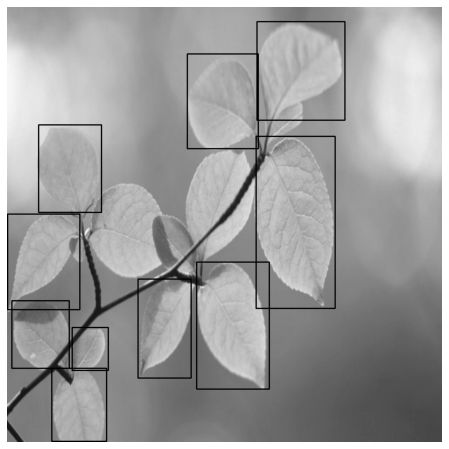

In [ ]:
it = iter(train_data_loader)
get_sample_image(it)

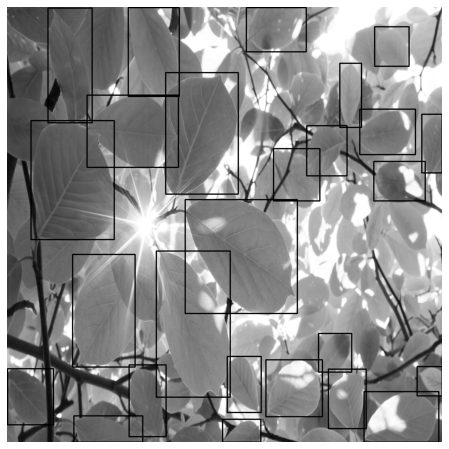

In [ ]:
get_sample_image(it)

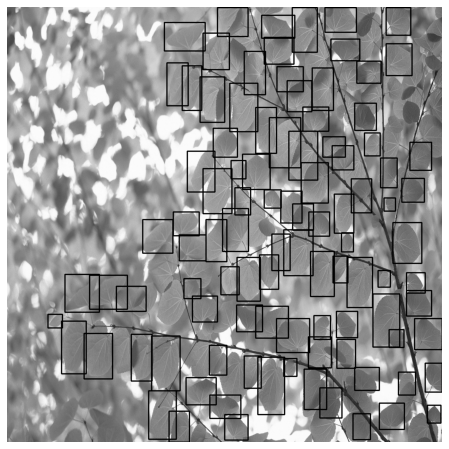

In [ ]:
get_sample_image(it)

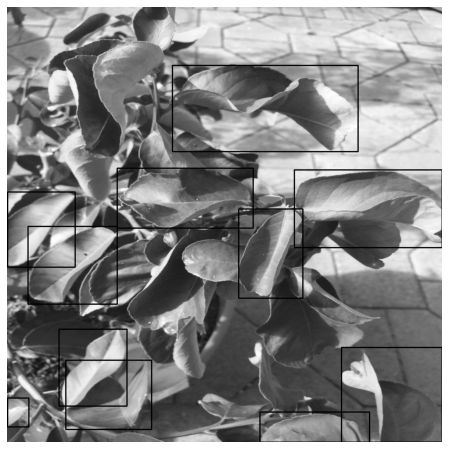

In [ ]:
get_sample_image(it)

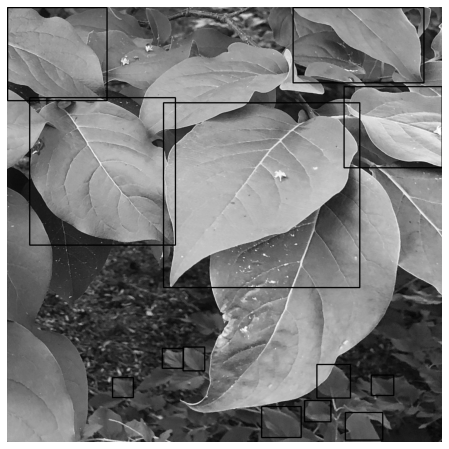

In [ ]:
get_sample_image(it)

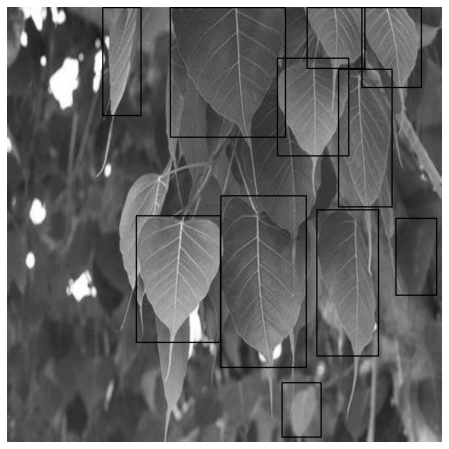

In [ ]:
get_sample_image(it)

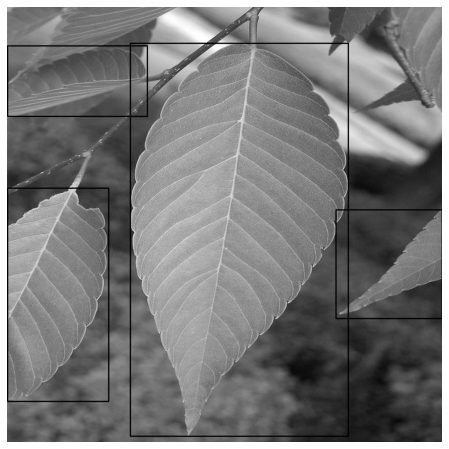

In [ ]:
get_sample_image(it)

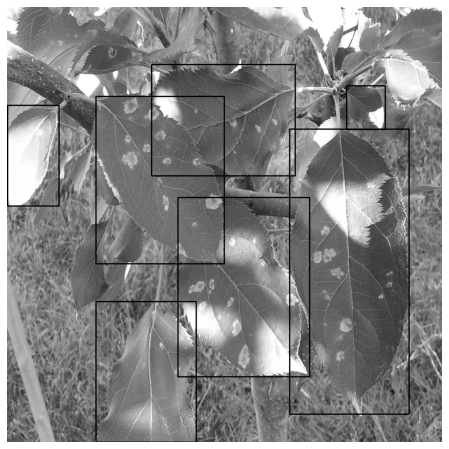

In [ ]:
get_sample_image(it)

# Loading ResNet50 trained on COCO

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)



In [ ]:

num_classes = 2  # 1 class (leaf) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


In [ ]:
model.to(device)
print("Model loaded")

Model loaded


# Training

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
# lr_scheduler = None
num_epochs = 15

NameError: ignored

In [ ]:
loss_hist = Averager()
itr = 1

previous_epoch = 1000
es_rate = 0

es_threshold = 2 # How many epochs without improvement to early stop


for epoch in range(num_epochs):
    loss_hist.reset()
    min_loss = 1000
    for images, targets, image_ids in train_data_loader:
       
        images = list(image.to(device) for image in images)
       
        targets = [{k: v.to(device) for k,v in t.items()} for t in targets]
       
        loss_dict = model(images, targets)
      
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")
        
        itr += 1
                
            
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()
    min_loss = loss_hist.value
    
    if min_loss < previous_epoch:
        previous_epoch = min_loss
        es_rate = 0
        
    else:
        if es_rate < es_threshold:
            es_rate += 1
        elif es_rate >= es_threshold:
            break
    print(f"Epoch #{epoch} loss: {loss_hist.value}")   


Iteration #50 loss: 0.19723913073539734


KeyboardInterrupt: ignored

In [ ]:
print(loss_dict)

NameError: ignored

# Validation (On data from Training)

In [ ]:
model = torch.load('leaves_fasterrcnn_model_15epoch.h5')

In [223]:
it = iter(valid_data_loader)

(1024, 1024, 1)
(1024, 1024, 1)
(1024, 1024, 1)
(1024, 1024, 1)


Average precision is :  0.3333333333333333
Average precision is :  0.05
Average precision is :  0.6363636363636364
Average precision is :  0.125


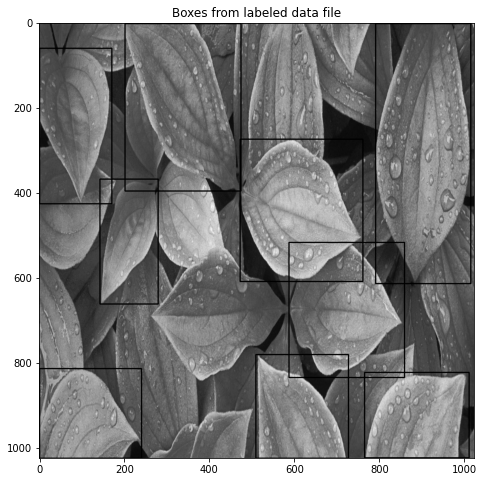

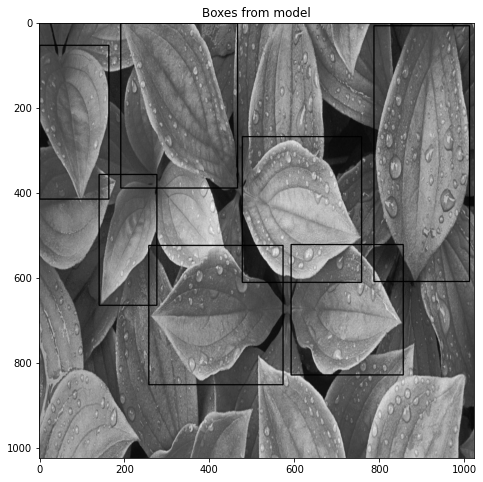

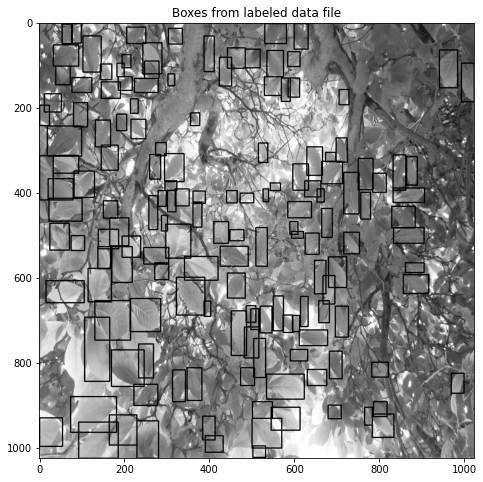

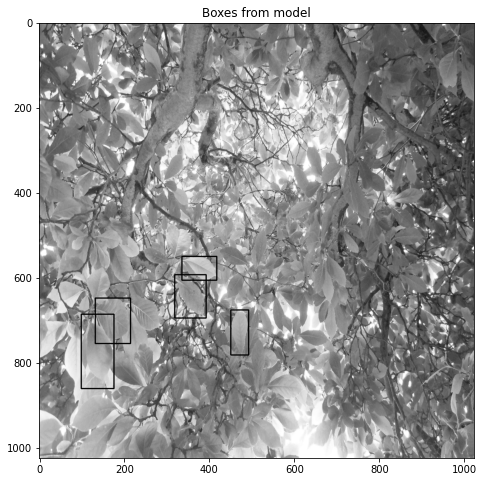

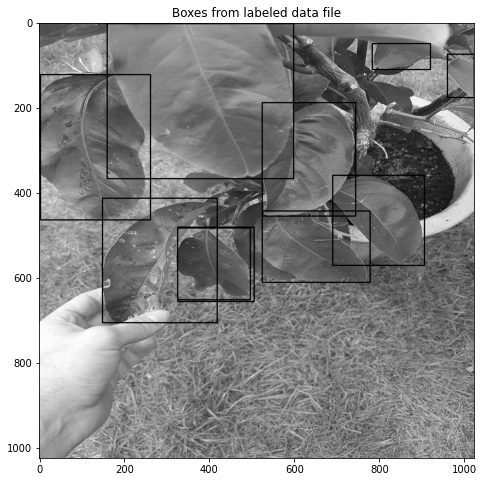

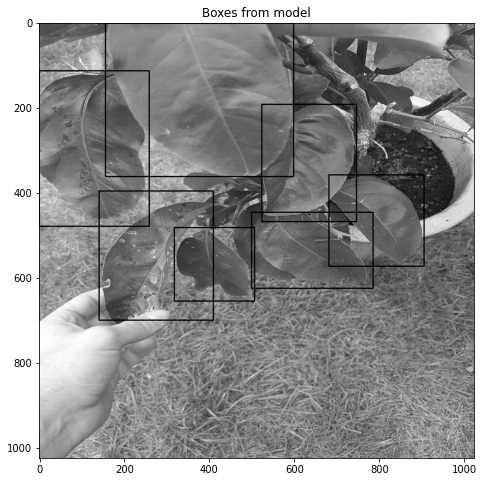

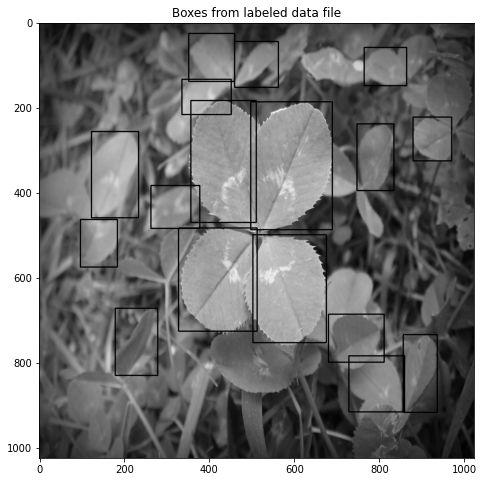

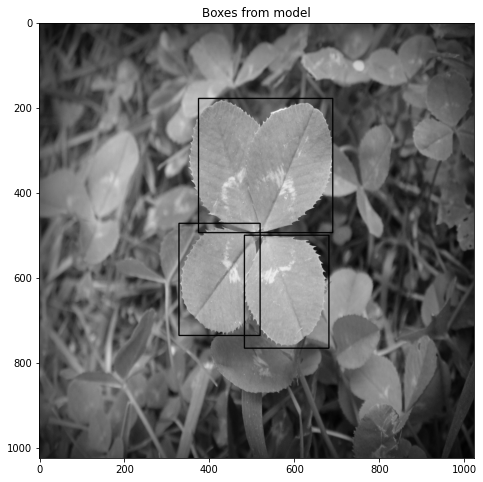

In [224]:
# for i in range(num_image):
#   start = time.time()
#   process_image(data_for_process,i,0.5)
#   print(time.time()-start)
get_validation_image(it)

Average precision is :  0.75
Average precision is :  1.0
Average precision is :  1.0
Average precision is :  0.4


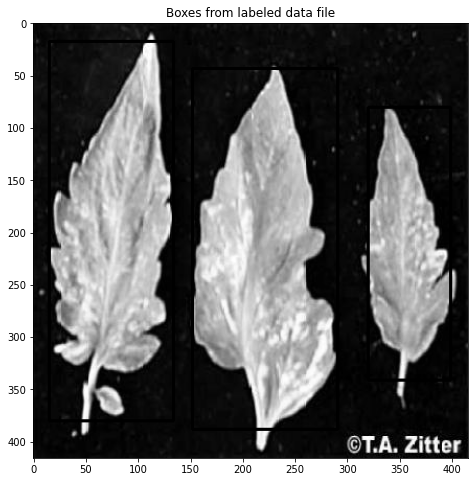

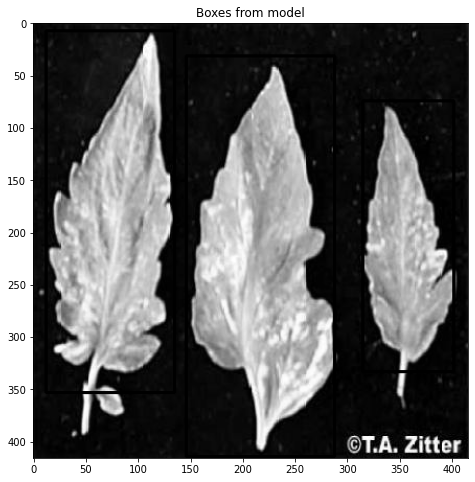

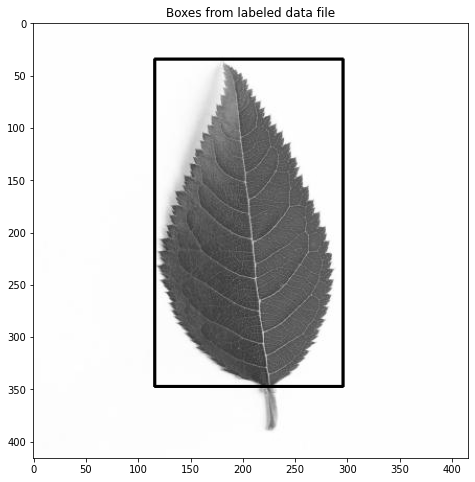

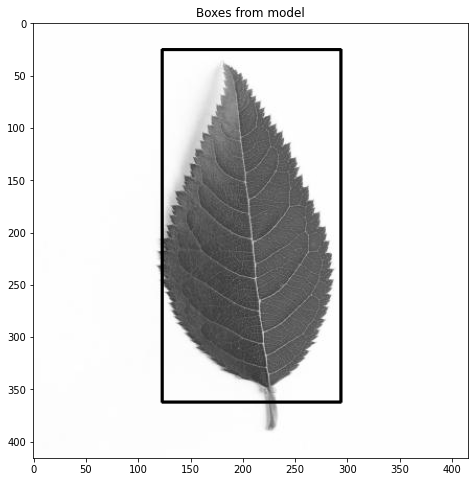

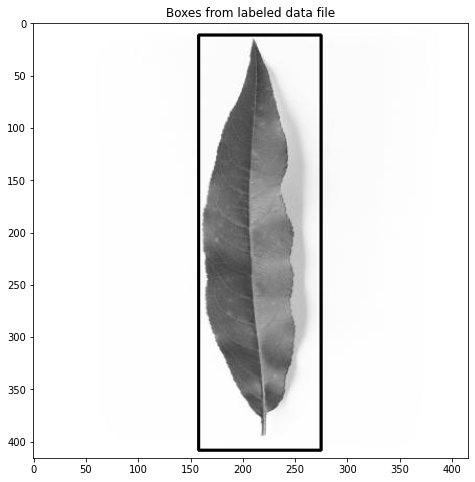

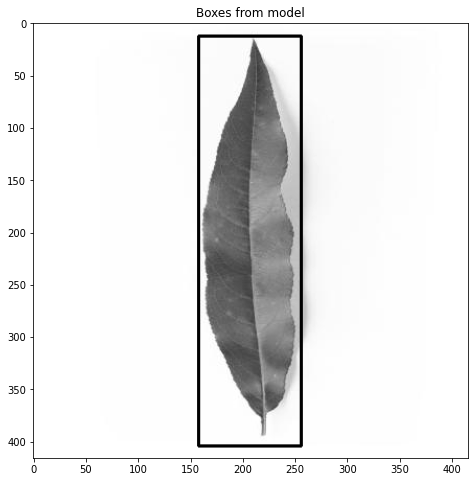

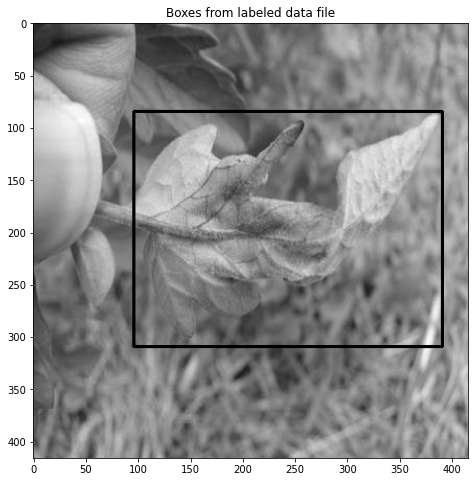

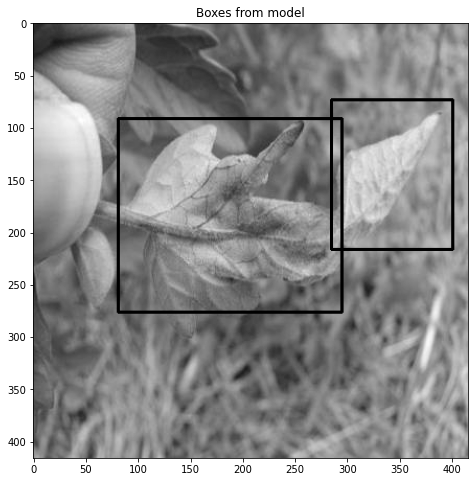

In [177]:
get_validation_image(it)

# Testing

In [ ]:
image_list = os.listdir(DIR_TEST+"/leaf")
print(image_list)

['Ginkgo_Biloba.jpg', 'TEST_004.jpg', 'TEST_002.jpg', 'TEST_006.jpg', 'TEST_001.jpg', '.ipynb_checkpoints', 'TEST_005.jpg', 'TEST_007.jpg', 'TEST_003.jpg']


In [ ]:
it = iter(load_test_dataset('/content/leaf-data/test'))


image shape
tensor([[[[0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
          [0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
          [0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.9922, 1.0000, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
          [0.9922, 1.0000, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
          [0.9922, 1.0000, 0.9961,  ..., 1.0000, 1.0000, 1.0000]]]])
after
image shape
torch.Size([1, 1, 1024, 1024])
after
torch.Size([1, 1, 1024, 1024])
(1024, 1024, 1)
(1024, 1024)
0.17618560791015625


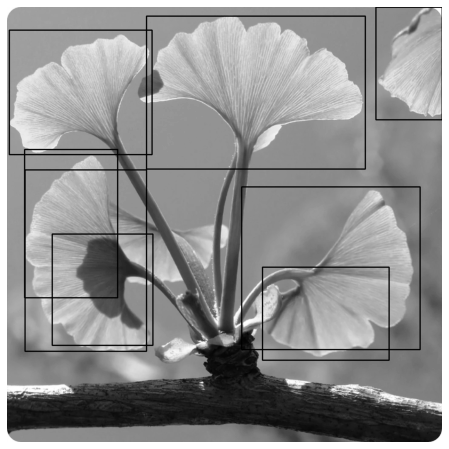

In [ ]:
start = time.time()
get_test_image(it,0.5)
print(time.time()-start)

image shape
torch.Size([1, 1, 1024, 1024])
after
image shape
torch.Size([1, 1, 1024, 1024])
after
torch.Size([1, 1, 1024, 1024])
(1024, 1024, 1)
(1024, 1024)
0.1673572063446045


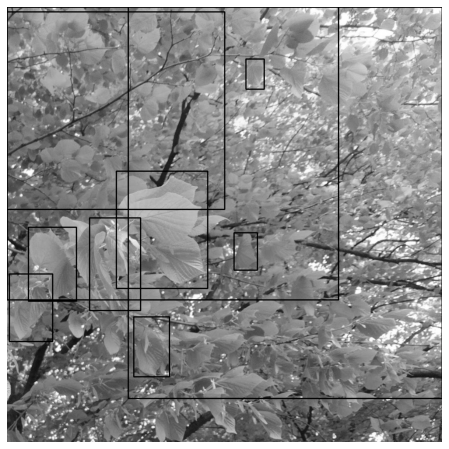

In [ ]:
start = time.time()
get_test_image(it,0.5)
print(time.time()-start)

image shape
torch.Size([1, 1, 1024, 1024])
after
image shape
torch.Size([1, 1, 1024, 1024])
after
torch.Size([1, 1, 1024, 1024])
(1024, 1024, 1)
(1024, 1024)
0.16233563423156738


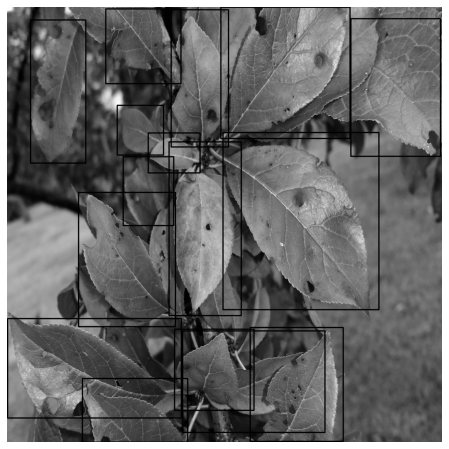

In [ ]:
start = time.time()
get_test_image(it,0.5)
print(time.time()-start)

image shape
tensor([[[[0.2353, 0.2235, 0.2118,  ..., 0.8431, 0.8510, 0.8549],
          [0.2353, 0.2275, 0.2235,  ..., 0.8471, 0.8549, 0.8588],
          [0.2392, 0.2353, 0.2392,  ..., 0.8510, 0.8588, 0.8627],
          ...,
          [0.4627, 0.4588, 0.4549,  ..., 0.8902, 0.9137, 0.9216],
          [0.4392, 0.4392, 0.4353,  ..., 0.8902, 0.9137, 0.9216],
          [0.4275, 0.4235, 0.4235,  ..., 0.8941, 0.9137, 0.9216]]]])
after
image shape
torch.Size([1, 1, 1024, 1024])
after
torch.Size([1, 1, 1024, 1024])
(1024, 1024, 1)
(1024, 1024)
0.16491222381591797


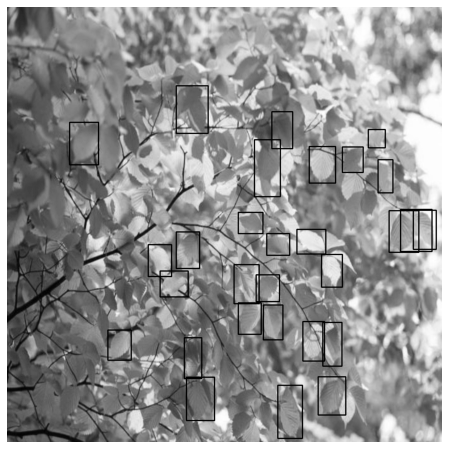

In [ ]:
start = time.time()
get_test_image(it,0.50)
print(time.time()-start)

image shape
tensor([[[[0.4314, 0.5373, 0.5922,  ..., 0.9961, 0.9961, 0.9961],
          [0.4000, 0.4980, 0.5529,  ..., 0.9961, 0.9961, 0.9961],
          [0.4039, 0.4824, 0.5451,  ..., 0.9961, 0.9961, 0.9961],
          ...,
          [0.4118, 0.4118, 0.4392,  ..., 0.2549, 0.2627, 0.2667],
          [0.4314, 0.4118, 0.4235,  ..., 0.2588, 0.2510, 0.2235],
          [0.4431, 0.4000, 0.4118,  ..., 0.2824, 0.2510, 0.1529]]]])
after
image shape
torch.Size([1, 1, 1024, 1024])
after
torch.Size([1, 1, 1024, 1024])
(1024, 1024, 1)
(1024, 1024)
0.1631913185119629


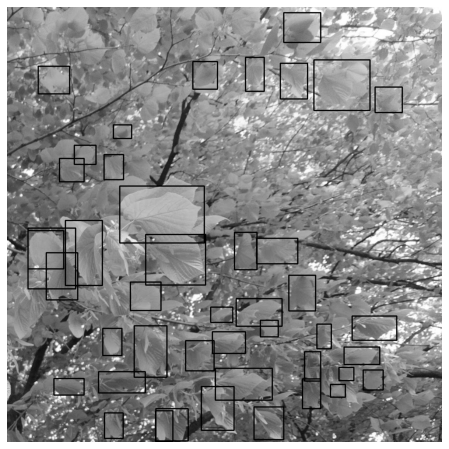

In [ ]:
start = time.time()
get_test_image(it,0.50)
print(time.time()-start)

#Save model

In [ ]:
!pip install pyyaml h5py

In [ ]:
print(tf.version.VERSION)

2.4.1


In [ ]:
#save as a hdf5
torch.save(model, 'leaves_fasterrcnn_model_15epoch.h5')

In [ ]:
torch.save(model, 'leaves_fasterrcnn_model_15_epoch.pth')

In [ ]:
filename = 'final_model_15epoch.sav'

In [ ]:
torch.save(model, filename)

In [ ]:
from keras.models import load_model
# model = load_model('/content/leaves_fasterrcnn_model_15_epoch.pth')
# print("Model loaded")

#Read model and process data

In [ ]:
model = torch.load('leaves_fasterrcnn_model_15epoch.h5')
print(loss_hist)


AttributeError: ignored

In [ ]:
one_image = os.listdir('/content/data/leaf')
num_image = len(one_image)
print(one_image);
print(num_image)

['cheense_tulip.jpg', '.ipynb_checkpoints']
2


In [ ]:
data_for_process = iter(load_test_dataset('data'))

torch.Size([1, 1, 416, 416])
416
416
cheense_tulip.jpg
[{'boxes': tensor([[1.0972e+01, 9.3597e+01, 2.0831e+02, 3.0260e+02],
        [2.1377e+02, 1.8939e+02, 3.8520e+02, 3.8033e+02],
        [2.2026e+02, 7.7698e+01, 3.1323e+02, 1.9989e+02],
        [2.0424e+02, 6.3329e-01, 3.6914e+02, 6.9449e+01],
        [7.9260e+01, 1.1081e+00, 2.1295e+02, 8.3254e+01],
        [3.1899e+02, 0.0000e+00, 4.1415e+02, 1.5028e+02],
        [1.5029e+02, 3.6413e+02, 2.8834e+02, 4.1382e+02],
        [1.1454e-01, 3.2221e+02, 7.2120e+01, 4.1108e+02],
        [2.8401e+01, 2.6272e+02, 1.5253e+02, 3.4957e+02],
        [2.0907e+02, 2.3111e+02, 3.1692e+02, 3.7820e+02],
        [8.6762e+01, 3.6457e+01, 1.8936e+02, 8.3788e+01]], device='cuda:0',
       grad_fn=<StackBackward>), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9907, 0.9800, 0.9711, 0.9253, 0.7494, 0.6410, 0.6122, 0.5400, 0.2446,
        0.0805, 0.0526], device='cuda:0', grad_fn=<IndexBackward>)}]
torch.Size([1, 1

StopIteration: ignored

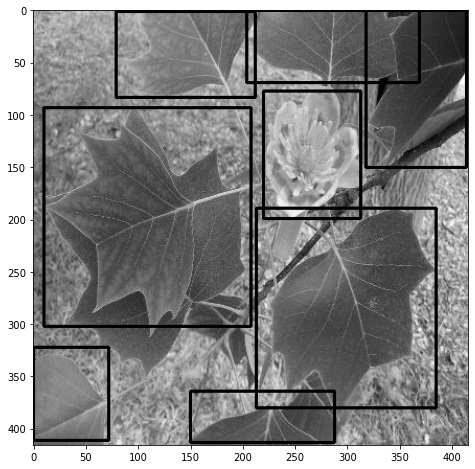

In [ ]:

for i in range(num_image):
  start = time.time()
  process_image(data_for_process,i,0.5)
  print(time.time()-start)